<a href="https://colab.research.google.com/github/ayushs0911/Projects/blob/main/Emotions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [2]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 96% 116M/121M [00:01<00:00, 121MB/s]
100% 121M/121M [00:01<00:00, 112MB/s]


In [61]:
# !unzip "/content/face-expression-recognition-dataset.zip" -d "/content/dataset/"

In [4]:
train_directory = "/content/dataset/images/train"
validation_directory = "/content/dataset/images/validation"

In [5]:
import os 
if not os.path.exists('helper_functions.py'):
  !wget https://raw.githubusercontent.com/ayushs0911/Projects/main/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' already exists.skipping download.")

--2023-04-29 02:35:44--  https://raw.githubusercontent.com/ayushs0911/Projects/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-29 02:35:44 (98.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [49]:
from helper_functions import walk_through_dir, calculate_results, plot_loss_curves, create_tensorboard_callback, make_confusion_matrix

In [7]:
walk_through_dir(train_directory)

There are 7 directories and 0 images in '/content/dataset/images/train'.
There are 0 directories and 7164 images in '/content/dataset/images/train/happy'.
There are 0 directories and 3993 images in '/content/dataset/images/train/angry'.
There are 0 directories and 3205 images in '/content/dataset/images/train/surprise'.
There are 0 directories and 4982 images in '/content/dataset/images/train/neutral'.
There are 0 directories and 436 images in '/content/dataset/images/train/disgust'.
There are 0 directories and 4103 images in '/content/dataset/images/train/fear'.
There are 0 directories and 4938 images in '/content/dataset/images/train/sad'.


In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory, 
    labels = "inferred", #labels generated from directory structure 
    label_mode = 'categorical',  
    class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (256,256),
    shuffle = True, 
    seed = 99

)

Found 28821 files belonging to 7 classes.


In [9]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory, 
    labels = "inferred", #labels generated from directory structure 
    label_mode = 'categorical', #lables are encoded as integers 
    class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (256,256),
    shuffle = True, 
    seed = 99
)

Found 7066 files belonging to 7 classes.


In [ ]:
# for i in val_dataset.take(1):
#   print(i)

In [10]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

##Data Visualization

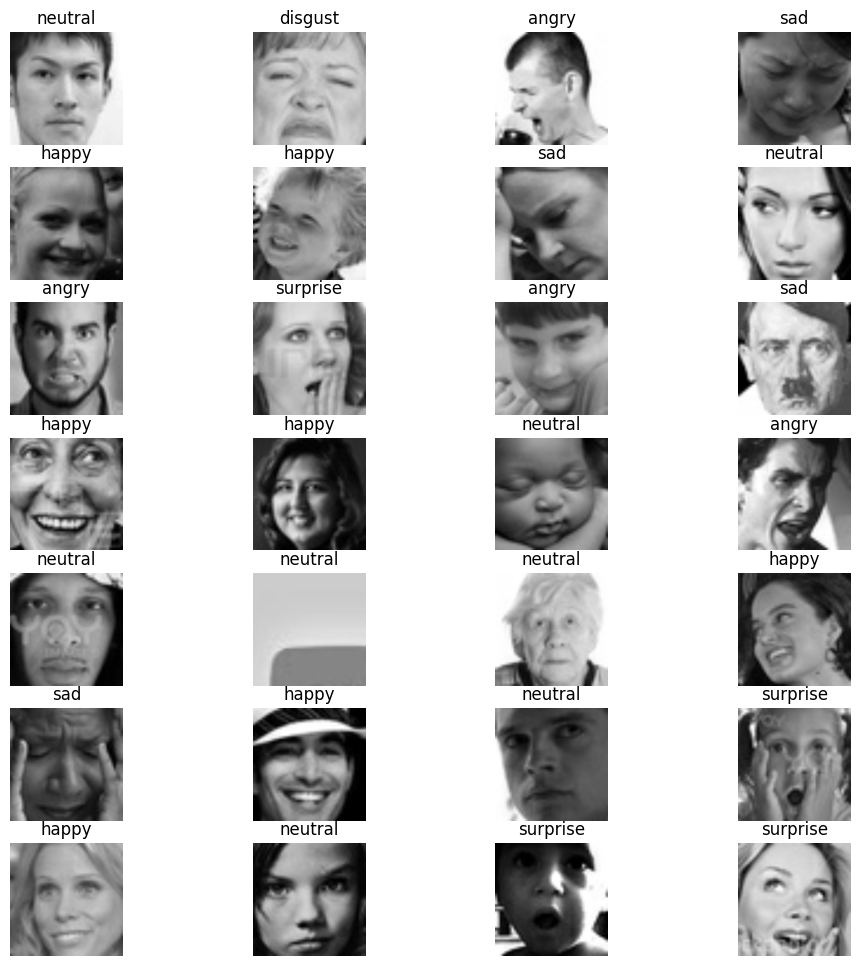

In [67]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(28):
    ax = plt.subplot(7,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(class_names[tf.argmax(labels[i]).numpy()])
    plt.axis("off")
    plt.savefig("data_viz")

<Figure size 640x480 with 0 Axes>

##Data Augmentation 

In [11]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    RandomFlip(mode = "horizontal"),
    RandomContrast(factor = 0.1)
])

In [12]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [13]:
training_dataset = (
    train_dataset.map(augment_layer, 
                      num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [14]:
validation_dataset = (
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [15]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(256,256),
    Rescaling(1./255)
])

In [16]:
training_dataset, validation_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>)

#Modelling

## Lenet

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = 6 , kernel_size =3, strides = 1 , padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
    Dropout(rate = 0),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu',),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),
    
    Dense(1024, activation = "relu",),
    BatchNormalization(),
    Dropout(rate = 0),
    
    Dense( 128, activation = "relu",),
    BatchNormalization(),

    Dense(7, activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

### Training Lenet 

In [ ]:
lenet_model.compile(optimizer = Adam(),
                    loss = CategoricalCrossentropy(),
                    metrics = ['accuracy'])

In [26]:
#early stopping
es_callback = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience =3,
    verbose =1,
    mode = 'auto',
    baseline = None, 
    restore_best_weights = False
)

#reducing learning rate in trainning 
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1
)
    

In [ ]:
history_lenet = lenet_model.fit(train_dataset,
                               epochs =20,
                               steps_per_epoch = len(train_dataset),
                               validation_data = val_dataset,
                               validation_steps = len(val_dataset),
                               callbacks = [es_callback,
                                            plateau_callback,
                                            create_tensorboard_callback('trainning_logs', 'lenet_model')])

Saving TensorBoard log files to: trainning_logs/lenet_model/20230428-155235
Epoch 1/20
901/901 [==============================] - 53s 54ms/step - loss: 0.1775 - accuracy: 0.9395 - val_loss: 4.3328 - val_accuracy: 0.3330 - lr: 0.0010
Epoch 2/20
901/901 [==============================] - 49s 54ms/step - loss: 0.1270 - accuracy: 0.9583 - val_loss: 2.8778 - val_accuracy: 0.4591 - lr: 0.0010
Epoch 3/20
901/901 [==============================] - 48s 53ms/step - loss: 0.0907 - accuracy: 0.9704 - val_loss: 2.8405 - val_accuracy: 0.4733 - lr: 0.0010
Epoch 4/20
901/901 [==============================] - 49s 54ms/step - loss: 0.1134 - accuracy: 0.9633 - val_loss: 10.4397 - val_accuracy: 0.1836 - lr: 0.0010
Epoch 5/20
901/901 [==============================] - 49s 54ms/step - loss: 0.5043 - accuracy: 0.8352 - val_loss: 2.2028 - val_accuracy: 0.4519 - lr: 0.0010
Epoch 6/20
901/901 [==============================] - 48s 54ms/step - loss: 0.1676 - accuracy: 0.9457 - val_loss: 3.0102 - val_accuracy: 0

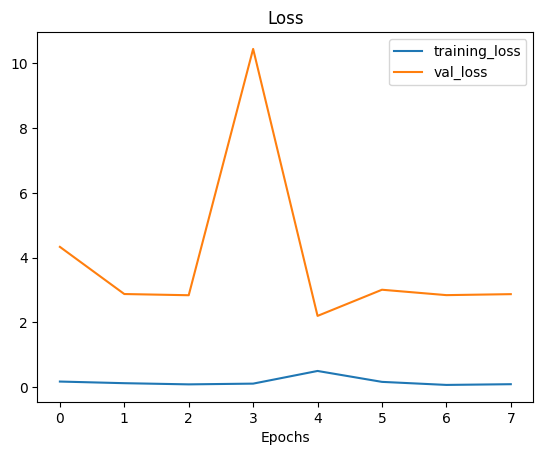

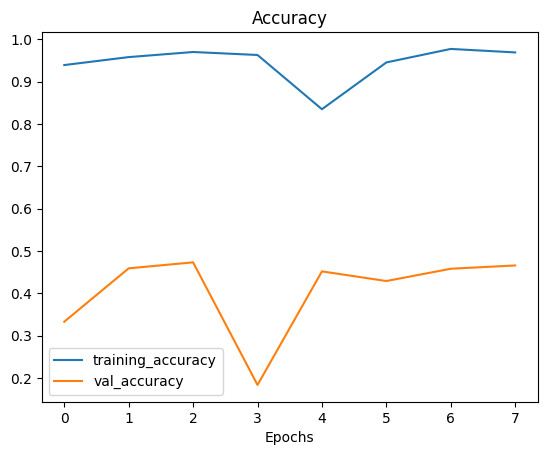

In [ ]:
plot_loss_curves(history_lenet)

##ResNet 34

###Custom Conv2D

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)
    
    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

###Residual Block



The `ResidualBlock` class is defined as a subclass of the Layer class. The class takes two arguments: `n_channels`, which specifies the number of output channels for each convolutional layer, and `n_strides`, which specifies the stride length for the first convolutional layer in the block.

Overall, this residual block can be used as a building block in a ResNet model to improve the model's performance on very deep architectures. The block uses skip connections to allow the gradient to flow directly through the block, which helps to alleviate the vanishing gradient problem and enables the successful training of very deep neural networks.

In [ ]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)
    
  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


### Complete Network 



The `ResNet34` class extends the Model class from TensorFlow and defines the architecture of the ResNet34 model. The model consists of several convolutional layers followed by residual blocks, which are a set of convolutional layers stacked on top of each other with shortcut connections that bypass one or more layers to improve gradient flow during backpropagation.

The `__init__ `method initializes the layers of the model. The first layer is a `CustomConv2D` layer with 64 filters, `kernel size` of 7x7, `stride` of 2, and same `padding`. The next layer is a max pooling layer with a `pool size` of 3x3 and `stride` of 2.

After that, there are multiple residual blocks, each containing several CustomConv2D layers followed by an Activation layer. 
- The first three residual blocks contain 64 filters, the next four contain 128 filters, the next six contain 256 filters, and the last three contain 512 filters. 
- The second convolutional layer in the first residual block of each block has a stride of 2, which downsamples the feature maps.

Finally, there is a global average pooling layer followed by a fully connected layer with softmax activation to produce the output probabilities.

The call method defines how the input is propagated through the layers of the model during the forward pass. It first passes the input through the initial CustomConv2D and max pooling layers, then through each residual block in sequence. After the final residual block, the output is passed through the global average pooling layer and the fully connected layer to produce the output probabilities. The training parameter is passed to each layer to enable/disable certain training-specific behaviors, such as batch normalization.

In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')
    
    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)
    
    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)
    
    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)
    
    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(7, activation = 'softmax')
    
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)
    
    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)
    
    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)
    
    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)
    
    return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

### Training ResNet34

In [ ]:
resnet_34.compile(optimizer = Adam(),
                  loss = CategoricalCrossentropy(),
                  metrics = ['accuracy'])

In [ ]:
history_resnet = resnet_34.fit(train_dataset,
                               epochs =20,
                               steps_per_epoch = len(train_dataset),
                               validation_data = val_dataset,
                               validation_steps = len(val_dataset),
                               callbacks = [es_callback,
                                            plateau_callback,
                                            create_tensorboard_callback('trainning_logs', 'resnet_34')])

Saving TensorBoard log files to: trainning_logs/resnet_34/20230428-160849
Epoch 1/20
901/901 [==============================] - 237s 232ms/step - loss: 1.7493 - accuracy: 0.3259 - val_loss: 2.4040 - val_accuracy: 0.1373 - lr: 0.0010
Epoch 2/20
901/901 [==============================] - 201s 223ms/step - loss: 1.4276 - accuracy: 0.4548 - val_loss: 1.9986 - val_accuracy: 0.4363 - lr: 0.0010
Epoch 3/20
901/901 [==============================] - 200s 222ms/step - loss: 1.2617 - accuracy: 0.5218 - val_loss: 1.3678 - val_accuracy: 0.4884 - lr: 0.0010
Epoch 4/20
901/901 [==============================] - 200s 221ms/step - loss: 1.1619 - accuracy: 0.5629 - val_loss: 1.2457 - val_accuracy: 0.5456 - lr: 0.0010
Epoch 5/20
901/901 [==============================] - 200s 222ms/step - loss: 1.0966 - accuracy: 0.5892 - val_loss: 1.2710 - val_accuracy: 0.5201 - lr: 0.0010
Epoch 6/20
901/901 [==============================] - 201s 222ms/step - loss: 1.0196 - accuracy: 0.6195 - val_loss: 1.2254 - val_ac

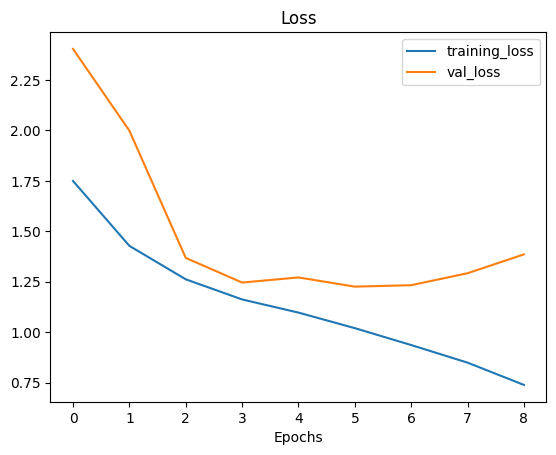

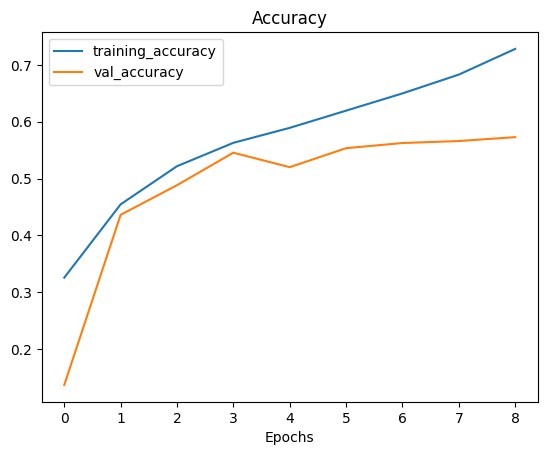

In [ ]:
plot_loss_curves(history_resnet)

##Transfer Learning with efficient Net

In [ ]:
backbone = tf.keras.applications.EfficientNetB4(
    include_top = False, 
    weights = 'imagenet',
    input_shape = (256, 256, 3)
)

71686520/71686520 [==============================] - 5s 0us/step


In [ ]:
backbone.trainable = False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (256,256,3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(1024, activation = "relu"),
    BatchNormalization(),
    Dense(128, activation = "relu"),
    Dense(7, activation = "softmax")
])

In [ ]:
pretrained_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_40 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 128)               131200    
                                                                 
 dense_6 (Dense)             (None, 7)                

In [ ]:
pretrained_model.compile(optimizer = Adam(),
                  loss = CategoricalCrossentropy(),
                  metrics = ['accuracy'])

In [ ]:
history_pretrained = pretrained_model.fit(train_dataset,
                               epochs =20,
                               steps_per_epoch = len(train_dataset),
                               validation_data = val_dataset,
                               validation_steps = len(val_dataset),
                               callbacks = [es_callback,
                                            plateau_callback,
                                            create_tensorboard_callback('trainning_logs', 'pretrained_model')])

Saving TensorBoard log files to: trainning_logs/pretrained_model/20230428-164242
Epoch 1/20
901/901 [==============================] - 237s 244ms/step - loss: 1.4705 - accuracy: 0.4619 - val_loss: 1.3441 - val_accuracy: 0.5062 - lr: 0.0010
Epoch 2/20
901/901 [==============================] - 215s 239ms/step - loss: 1.2565 - accuracy: 0.5224 - val_loss: 1.2953 - val_accuracy: 0.5347 - lr: 0.0010
Epoch 3/20
901/901 [==============================] - 215s 238ms/step - loss: 1.1936 - accuracy: 0.5463 - val_loss: 1.2524 - val_accuracy: 0.5468 - lr: 0.0010
Epoch 4/20
901/901 [==============================] - 215s 238ms/step - loss: 1.1527 - accuracy: 0.5647 - val_loss: 1.2215 - val_accuracy: 0.5623 - lr: 0.0010
Epoch 5/20
901/901 [==============================] - 214s 237ms/step - loss: 1.1192 - accuracy: 0.5783 - val_loss: 1.2366 - val_accuracy: 0.5541 - lr: 0.0010
Epoch 6/20
901/901 [==============================] - 215s 238ms/step - loss: 1.0815 - accuracy: 0.5955 - val_loss: 1.3395 -

##Fine Tuning Efficient Net

In [ ]:
backbone.trainable = True 

In [ ]:
input = Input(shape = (256,256,3))

x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense(128, activation = "relu")(x)
output = Dense(7, activation = "softmax")(x)

finetuned_model = Model(input, output)

In [ ]:
finetuned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_2   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_41 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 128)               131200

In [ ]:
finetuned_model.compile(optimizer = Adam(learning_rate = 1e-4),
                  loss = CategoricalCrossentropy(),
                  metrics = ['accuracy'])

In [ ]:
history_finetuned = finetuned_model.fit(train_dataset,
                               epochs =20,
                               steps_per_epoch = len(train_dataset),
                               validation_data = val_dataset,
                               validation_steps = len(val_dataset),
                               callbacks = [es_callback,
                                            plateau_callback,
                                            create_tensorboard_callback('trainning_logs', 'finetuned_model')])

Saving TensorBoard log files to: trainning_logs/finetuned_model/20230428-171448
Epoch 1/20
901/901 [==============================] - 825s 816ms/step - loss: 1.1483 - accuracy: 0.5751 - val_loss: 1.1664 - val_accuracy: 0.6127 - lr: 1.0000e-04
Epoch 2/20
901/901 [==============================] - 727s 806ms/step - loss: 0.8517 - accuracy: 0.6862 - val_loss: 0.9690 - val_accuracy: 0.6609 - lr: 1.0000e-04
Epoch 3/20
901/901 [==============================] - 727s 807ms/step - loss: 0.6314 - accuracy: 0.7711 - val_loss: 1.0801 - val_accuracy: 0.6620 - lr: 1.0000e-04
Epoch 4/20
901/901 [==============================] - 727s 807ms/step - loss: 0.3961 - accuracy: 0.8581 - val_loss: 1.3879 - val_accuracy: 0.6620 - lr: 1.0000e-04
Epoch 5/20
901/901 [==============================] - 727s 806ms/step - loss: 0.2466 - accuracy: 0.9137 - val_loss: 1.7534 - val_accuracy: 0.6388 - lr: 1.0000e-04
Epoch 5: early stopping


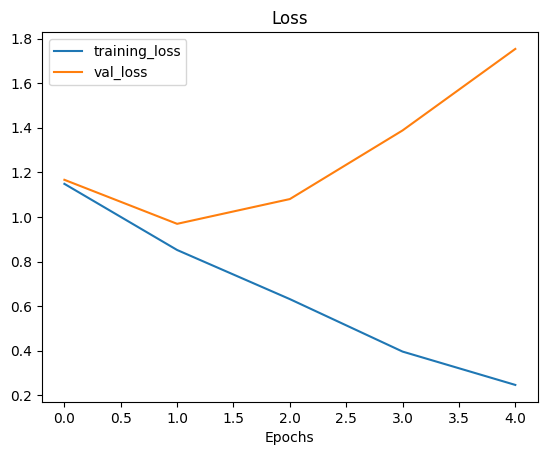

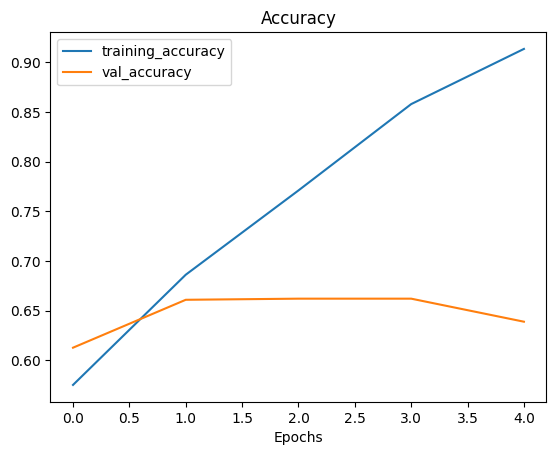

In [ ]:
plot_loss_curves(history_finetuned)

##Vision Transformers



ViT models use **self-attention mechanisms**, where every image patch is treated as a "token" and is processed by a self-attention layer to attend to other patches in the image. The output of these self-attention layers is passed through a **multi-layer perceptron (MLP)** to compute the final classification output. This approach is different from traditional convolutional neural networks (CNNs), which use convolutional layers to extract features and perform classification.

The ViT architecture is typically composed of several blocks, each containing a self-attention layer followed by a MLP block. The output of each block is then passed to the next block. The first block usually processes the image patches with a learnable embedding matrix, followed by positional encoding to preserve the spatial relationships between the patches. The subsequent blocks operate on the output of the previous block and use layer normalization to improve the stability of training.

One of the main benefits of ViT is that it is more flexible than CNNs in terms of the input size and resolution. ViT can process input images of arbitrary size, and during training, the image is randomly cropped and resized to multiple resolutions. This helps to improve the generalization performance of the model. 

In [ ]:
test_image = cv2.imread("/content/dataset/images/train/happy/10005.jpg")
test_image = cv2.resize(test_image, (256,256))

`tf.image.extract_patches()` is a function from TensorFlow's Image module used to extract non-overlapping patches from an image. Here's a brief explanation of the function arguments:

- `sizes`: size of the patch to be extracted from the input image. It takes a list of four integers: `[batch_size, patch_height, patch_width, channels]`. 
- `strides`: takes a list of four integers: `[batch_size, stride_height, stride_width, channels]`. Here, `batch_size` is 1, and `stride_height` and `stride_width` are equal to `16`, which means that patches are non-overlapping.
- `rates`: This argument specifies the dilation rate between pixels within a patch. It takes a list of four integers: `[batch_size, rate_height, rate_width, channels]`. Here, all values are set to 1, meaning there is no dilation within the patch.
- `padding`: value is set to `'VALID'`, meaning no padding is added to the input image.

The output of this function is a tensor of shape `[batch_size, output_height, output_width, patch_height*patch_width*channels]`, where `batch_size` is 1, and `output_height` and `output_width` depend on the size of the input image and the patch size specified in the `sizes` argument. The last dimension of the output tensor represents the flattened patches extracted from the input image.

In [ ]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0),
                           sizes=[1, 16, 16, 1],
                           strides=[1, 16, 16, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [ ]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


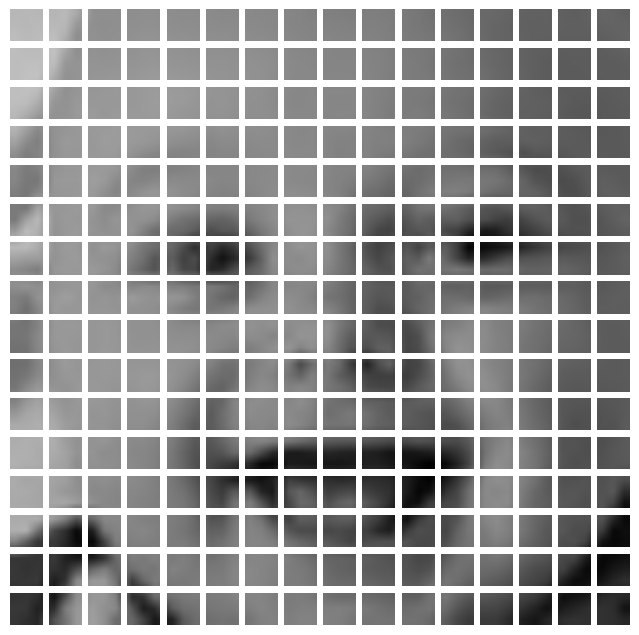

In [ ]:
plt.figure(figsize = (8,8))

for i in range(patches.shape[1]):

  ax = plt.subplot(16,16, i+1)
  plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
  plt.axis("off")

### Path Encoder

This code defines a custom layer called `PatchEncoder`, which is a part of the Vision Transformer model. 

The `PatchEncoder` layer is responsible for encoding image patches into fixed-size feature vectors, which will be inputted into the Transformer model. The layer takes two arguments: `N_PATCHES`, which is the total number of patches in the image, and `HIDDEN_SIZE`, which is the size of the output feature vectors.

The `__init__` method defines two sub-layers, `linear_projection` and `positional_embedding`, which are used to encode the patches. The `linear_projection` layer is a fully connected layer that transforms the patches into feature vectors of size `HIDDEN_SIZE`. The `positional_embedding` layer adds position embeddings to the feature vectors, which help to distinguish the position of each patch in the image. The size of the `positional_embedding` layer is also set to `HIDDEN_SIZE`.

The `call` method performs the actual patch encoding. 
- First, the method extracts patches from the input image using the `tf.image.extract_patches` function. The `sizes` argument specifies the size of each patch, which is `[1, 16, 16, 1]`. 
- The `strides` argument specifies the stride of the sliding window used to extract the patches, which is also `[1, 16, 16, 1]`. 
- The `rates` argument specifies the dilation rate, which is `[1, 1, 1, 1]`. The `padding` argument specifies the padding type, which is `'VALID'`. The result of this operation is a 4D tensor with shape `[batch_size, n_patches_vertical, n_patches_horizontal, patch_size * patch_size * n_channels]`.

Next, the method reshapes the patches tensor into a 3D tensor of shape `[batch_size, n_patches, patch_size * patch_size * n_channels]`. This is achieved by flattening the last two dimensions of the tensor and combining the first two dimensions.

Then, the method generates a 1D tensor of shape `[n_patches]` that contains the indices of the patches in the image. This is done using the `tf.range` function. These indices are used to compute the positional embeddings.

Finally, the method applies the `linear_projection` and `positional_embedding` sub-layers to the patches tensor to generate the encoded feature vectors. The two sub-layers are applied in parallel, and their outputs are added element-wise to produce the final output. The output of the `PatchEncoder` layer is a tensor of shape `[batch_size, n_patches, hidden_size]`, where `hidden_size` is the size of the output feature vectors.

In [ ]:
class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE )
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, 16, 16, 1],
        strides=[1, 16, 16, 1],
        rates=[1, 1, 1, 1],
        padding='VALID')
    
    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))
    
    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 )
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)
    
    return output

### Transformer Encoder 

This code defines a custom Keras layer `TransformerEncoder` which implements a transformer encoder block.  
The layer has two input arguments: `N_HEADS` which specifies the number of attention heads in the multi-head attention layer and `HIDDEN_SIZE` which specifies the hidden dimension size of the dense layers.

The constructor initializes the following components:
- Two layer normalization layers `self.layer_norm_1` and `self.layer_norm_2` which are applied before and after the multi-head attention and dense layers, respectively.
- A `MultiHeadAttention` layer `self.multi_head_att` which is the multi-head attention layer used in the transformer encoder.
- Two dense layers `self.dense_1` and `self.dense_2` with the `relu` activation function which are used to transform the output of the multi-head attention layer.

The `call` method takes an input tensor `input` and first applies the layer normalization `self.layer_norm_1`. Then it passes the result through the multi-head attention layer `self.multi_head_att` with itself as both the query and key-value inputs. The output of the multi-head attention layer is added with the original input tensor and the result is passed through the second layer normalization layer `self.layer_norm_2`. Finally, the result is passed through the two dense layers `self.dense_1` and `self.dense_2`, and the output is added with the output from the first layer normalization layer. The final output is returned.

In [ ]:
class TransformerEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()
    
    self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE )
    
    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    
  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output

### ViT Model



This is the implementation of the ViT (Vision Transformer) model in Keras. 

- The `ViT` class is defined as a subclass of the `Model` class from Keras. It takes the hyperparameters `N_HEADS`, `HIDDEN_SIZE`, `N_PATCHES`, `N_LAYERS`, and `N_DENSE_UNITS` as inputs.
- The `N_LAYERS` attribute is assigned to the number of transformer encoder layers to be used in the model.
- The `patch_encoder` attribute is assigned to an instance of the `PatchEncoder` class, which encodes the image patches and adds positional embeddings to them.
- The `trans_encoders` attribute is assigned to a list of `TransformerEncoder` instances, each of which applies multi-head self-attention and feedforward operations to the encoded patches.
- The `dense_1`, `dense_2`, and `dense_3` attributes are assigned to fully connected layers that are applied to the output of the transformer encoder layers.

*******

- The `call` method defines the forward pass of the model. It takes an input tensor and an optional `training` boolean flag as inputs.
- The input tensor is passed through the `patch_encoder` layer, which encodes the image patches and adds positional embeddings to them.
- The output of the `patch_encoder` layer is then passed through each of the `trans_encoders` layers in a loop, which applies multi-head self-attention and feedforward operations to the encoded patches.
- The output of the last transformer encoder layer is flattened and passed through the fully connected layers `dense_1` and `dense_2`.
- The output of the last fully connected layer `dense_2` is passed through the output layer `dense_3`, which outputs the predicted class probabilities for each input image.

In [ ]:
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(7, activation = 'softmax')
  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)
    
    return self.dense_3(x)

In [ ]:
vit = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 768, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 128)
vit(tf.zeros([2,256,256,3]))

<tf.Tensor: shape=(2, 7), dtype=float32, numpy=
array([[0.1763126 , 0.1397243 , 0.15808162, 0.16557918, 0.10520025,
        0.11536602, 0.13973606],
       [0.1763126 , 0.1397243 , 0.15808162, 0.16557918, 0.10520025,
        0.11536602, 0.13973606]], dtype=float32)>

In [ ]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncoder  multiple                 787200    
 )                                                               
                                                                 
 transformer_encoder (Transf  multiple                 10631424  
 ormerEncoder)                                                   
                                                                 
 transformer_encoder (Transf  multiple                 10631424  
 ormerEncoder)                                                   
                                                                 
 dense_15 (Dense)            multiple                  25165952  
                                                                 
 dense_16 (Dense)            multiple                  16512     
                                                

##Hugging Face Transformers 

###Installation

In [17]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.7 MB/s eta 0:00:00


###Training 

In [18]:
resize_rescale_hf = tf.keras.Sequential([
      Resizing(224,224), 
      Rescaling(1./255),
      Permute((3,1,2))
      
])

In [19]:
from transformers import ViTFeatureExtractor, TFViTModel


base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)[0][:,0,:]
#print(x)
output = Dense(7, activation = 'softmax')(x)

hf_model = tf.keras.Model(inputs=inputs, outputs=output)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [20]:
test_image = cv2.imread("/content/dataset/images/train/happy/10005.jpg")
test_image = cv2.resize(test_image, (256 ,256))

In [21]:
hf_model(tf.expand_dims(test_image, axis = 0))

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[0.14739266, 0.11189823, 0.1574924 , 0.17804074, 0.14580722,
        0.14868417, 0.1106846 ]], dtype=float32)>

In [22]:
hf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0     

### Get attention Maps

In [23]:
from transformers import ViTFeatureExtractor, TFViTModel, ViTConfig

configuration = ViTConfig()
configuration.output_attentions = True

base_model = TFViTModel.from_pretrained(
    pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k",
    config = configuration,
    )
inputs = Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)['attentions']

model = tf.keras.Model(inputs=inputs, outputs=x)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


### Training HuggingFace Transformer

In [28]:
hf_model.compile(optimizer= Adam(learning_rate = 5e-5), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

In [29]:
#create modelcheckpoint callback to save model's progress
checkpoint_path = 'model_checkpoint/cp.ckpt' #saving weigths requires '.ckpt' extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor ='val_accuracy',#saving model weights with best validation accuracy
                                                      save_best_only = True,# only save the best weights 
                                                      save_weights_only = True,#only save model weights (not whole model)
                                                      verbose =0)
     

In [31]:
history_hf = hf_model.fit(train_dataset,
                               epochs =20,
                               validation_data = val_dataset,
                               callbacks = [es_callback,
                                            plateau_callback,
                                            model_checkpoint,
                                            create_tensorboard_callback('trainning_logs', 'hf_model')])

Saving TensorBoard log files to: trainning_logs/hf_model/20230429-030524
Epoch 1/20
901/901 [==============================] - 1271s 1s/step - loss: 0.7406 - accuracy: 0.7293 - val_loss: 0.8703 - val_accuracy: 0.6903 - lr: 5.0000e-05
Epoch 2/20
901/901 [==============================] - 1265s 1s/step - loss: 0.5019 - accuracy: 0.8237 - val_loss: 0.9272 - val_accuracy: 0.6874 - lr: 5.0000e-05
Epoch 3/20
901/901 [==============================] - 1267s 1s/step - loss: 0.2883 - accuracy: 0.9065 - val_loss: 1.0950 - val_accuracy: 0.6797 - lr: 5.0000e-05
Epoch 4/20
901/901 [==============================] - 1268s 1s/step - loss: 0.1896 - accuracy: 0.9369 - val_loss: 1.2746 - val_accuracy: 0.6817 - lr: 5.0000e-05
Epoch 4: early stopping


Loading best weights

In [32]:
hf_model.load_weights(checkpoint_path)

#Testing

In [ ]:
lenet_results = lenet_model.evaluate(validation_dataset)

221/221 [==============================] - 10s 44ms/step - loss: 2.8740 - accuracy: 0.4659


In [ ]:
resnet_34_results = resnet_34.evaluate(validation_dataset)

221/221 [==============================] - 15s 66ms/step - loss: 1.3853 - accuracy: 0.5729


In [ ]:
pretrained_model_results = pretrained_model.evaluate(validation_dataset)

221/221 [==============================] - 41s 183ms/step - loss: 2.9249 - accuracy: 0.3402


In [ ]:
finetuned_model_results = finetuned_model.evaluate(validation_dataset)

221/221 [==============================] - 41s 183ms/step - loss: 1.7534 - accuracy: 0.6388


In [33]:
hf_model_results = hf_model.evaluate(validation_dataset)

221/221 [==============================] - 102s 461ms/step - loss: 0.8703 - accuracy: 0.6903


Saving model to Google Drive 

In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [35]:
import os
from tensorflow.keras.models import save_model


# Save the trained model to a file
save_model(hf_model, os.path.join('/content/gdrive/My Drive', 'hf_model.h5'))


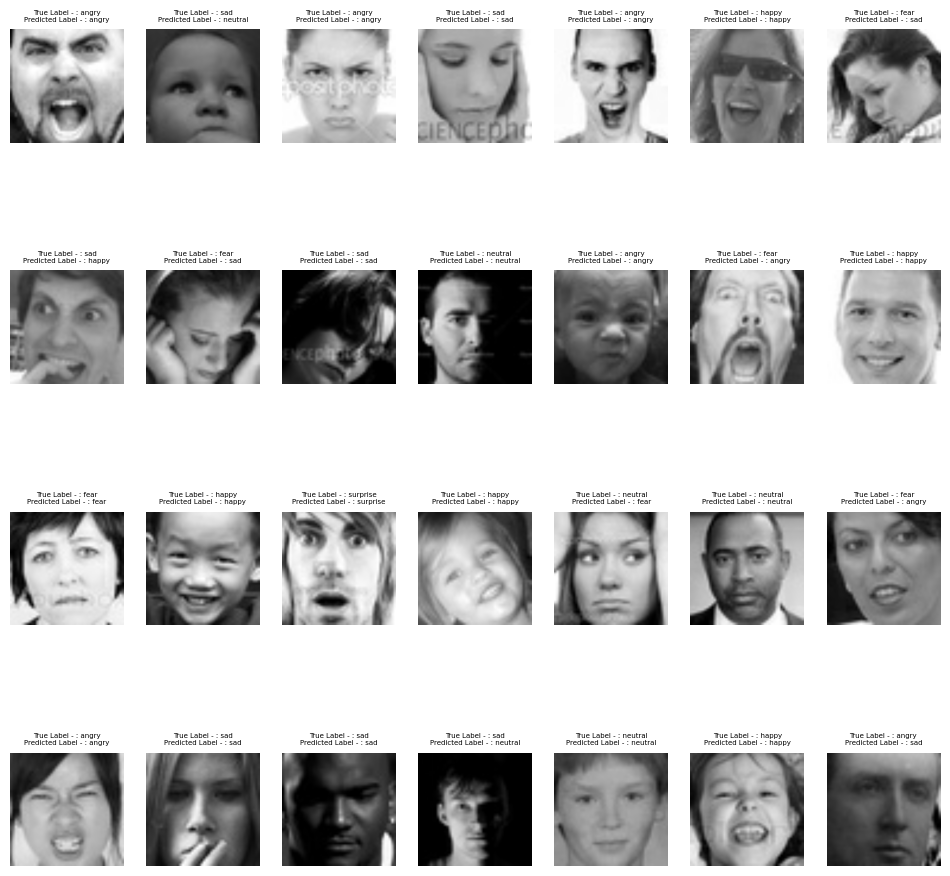

In [68]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(28):
    ax = plt.subplot(4,7, i+1)
    plt.imshow(images[i]/255.)

    plt.title("True Label - : " + class_names[tf.argmax(labels[i], axis = -1).numpy()] 
              + "\n" + "Predicted Label - : " 
              + class_names[int(tf.argmax(hf_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])], fontsize = 5 )
    plt.axis("off")
    plt.savefig("testing")

In [66]:
# plt.savefig("testing")

<Figure size 640x480 with 0 Axes>

#Confusion Matrix

In [37]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(hf_model(im))
  labels.append(label.numpy())

In [38]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

In [40]:
pred, lab

(array([4, 2, 4, ..., 0, 0, 3]), array([4, 2, 3, ..., 5, 2, 3]))

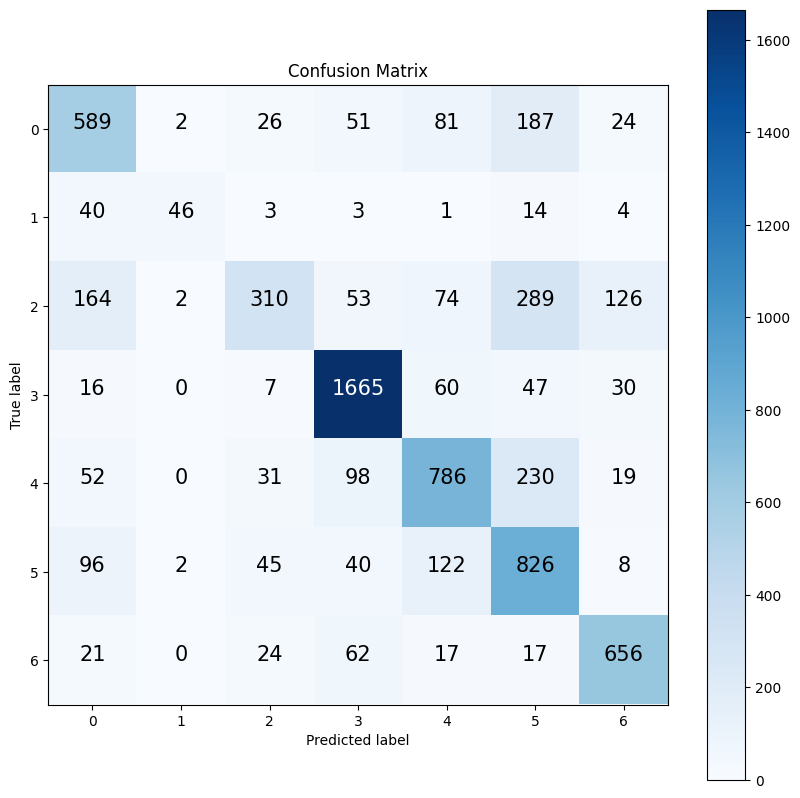

In [69]:
make_confusion_matrix(y_true = lab,
                  y_pred = pred)
plt.savefig("confusion_matriz")

In [65]:
# plt.savefig("confusion_matriz")

<Figure size 640x480 with 0 Axes>

# Loading Google Drive model 

In [57]:
loaded_model = tf.keras.models.load_model('/content/gdrive/My Drive/hf_model.h5')

In [58]:
loaded_model.evaluate(validation_dataset)

221/221 [==============================] - 106s 459ms/step - loss: 0.8703 - accuracy: 0.6903


[0.87027508020401, 0.6903481483459473]